In [213]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [214]:
FIGURE_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Code/figures/"
DATA_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/"
DATA_LOAD_PATH = DATA_PATH + "original_data/"
INPUT_MODEL_PATH = DATA_PATH + "processed_data/"
MODEL_SAVE_PATH = DATA_PATH + "trained_models/"
RESULTS_PATH = DATA_PATH + "model_results/"
path_to_shapefile = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/ne_110m_admin_0_countries.shp"
world = gpd.read_file(path_to_shapefile)
with open("functions_training_model.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)
df_empirical_Holocene = pd.read_csv(INPUT_MODEL_PATH + "df_empirical_Holocene.csv")
df_global_grid = pd.read_csv(INPUT_MODEL_PATH + "df_global_grid.csv")
df_wind = pd.read_csv(INPUT_MODEL_PATH + "df_wind.csv", usecols=['wind', 'latitude'])

latitude_wind = torch.tensor(df_wind['latitude'].values / 90, dtype=torch.float32)
mean_wind = torch.tensor(df_wind['wind'].values / df_wind['wind'].max(), dtype=torch.float32)


def wind_func(lat_tensor):
    # Interpolazione lineare in PyTorch
    return torch.interp(lat_tensor.flatten(), latitude_wind, mean_wind).unsqueeze(1)





In [215]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.SiLU()
        layer_list = []

        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                layer_list.append(self.activation)
        self.model = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.model(x)


In [216]:
# PDE
D= torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))
def pde_residual(model, x, wind_func, D):
    x.requires_grad_(True)
    u = model(x)

    grad_u = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivate parziali
    du_dx = grad_u[:, 0:1]
    du_dy = grad_u[:, 1:2]

    # Secondi ordini
    d2u_dx2 = autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0][:, 0:1]
    d2u_dy2 = autograd.grad(du_dy, x, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0][:, 1:2]

    # Coefficiente K in funzione della latitudine (seconda colonna di x)
    K = wind_func(x[:, 1:2])


    # Residuo PDE (esempio diffusione anisotropa)
    residual = (-K * du_dx * (1 / torch.cos(x[:, 1:2] * np.pi / 2)) + D * (
            (1 / (torch.cos(x[:, 1:2] * np.pi / 2) ** 2) * d2u_dx2 + d2u_dy2 - torch.tan(x[:, 1:2] * np.pi / 2) * du_dy)))
    return residual


In [217]:
# === PARAMETRI DEL DOMINIO ===
x_min, x_max = -2.0, 2.0
y_min, y_max = -0.89, 0.89

# === 1. DATI OSSERVATI ===
# Assumi che lon/lat siano già scalati correttamente in [-2, 2] e [-0.89, 0.89]
X_obs = torch.tensor(df_empirical_Holocene[['lon', 'lat']].values / 90, dtype=torch.float32)
Y_obs = torch.tensor(df_empirical_Holocene['log_dep_norm'].values.reshape(-1, 1), dtype=torch.float32)

# Verifica range
print("Range X_obs:", X_obs[:, 0].min().item(), X_obs[:, 0].max().item())
print("Range Y_obs:", X_obs[:, 1].min().item(), X_obs[:, 1].max().item())

# === 2. PUNTI INTERNI (PDE) ===
N_pde = 3000

xy_pde = torch.cat([
    torch.rand(N_pde, 1) * (x_max - x_min) + x_min,  # x in [x_min, x_max]
    torch.rand(N_pde, 1) * (y_max - y_min) + y_min   # y in [y_min, y_max]
], dim=1)

# === 3. CONDIZIONI AL CONTORNO DIRICHLET ===

# Nord: y = y_max
N_bc = 200
X_north = torch.rand(N_bc, 1) * (x_max - x_min) + x_min
Y_north = torch.full_like(X_north, y_max)
X_bc_north = torch.cat([X_north, Y_north], dim=1)
Y_bc_north = torch.full((N_bc, 1), -1.0)  # Valore BC nord

# Sud: y = y_min
X_south = torch.rand(N_bc, 1) * (x_max - x_min) + x_min
Y_south = torch.full_like(X_south, y_min)
X_bc_south = torch.cat([X_south, Y_south], dim=1)
Y_bc_south = torch.full((N_bc, 1), -2.0)  # Valore BC sud

# === 4. CONDIZIONI PERIODICHE (x = x_min e x = x_max) ===
N_periodic = 200
Y_periodic = torch.linspace(y_min, y_max, N_periodic).unsqueeze(1)

X_periodic_left = torch.full_like(Y_periodic, x_min)
X_periodic_right = torch.full_like(Y_periodic, x_max)

X_periodic_left = torch.cat([X_periodic_left, Y_periodic], dim=1)
X_periodic_right = torch.cat([X_periodic_right, Y_periodic], dim=1)


Range X_obs: -1.983555555343628 1.996666669845581
Range Y_obs: -0.8888888955116272 0.8763333559036255


In [218]:
# K in funzione della latitudine (normalizzata)
def wind_func(lat_tensor):
    return 1.0 + 0.5 * torch.sin(np.pi * lat_tensor)  # funzione fittizia


In [219]:
def total_loss(model, X_obs, Y_obs, xy_pde, X_bc1, Y_bc1,
               X_bc2, Y_bc2,X_periodic_left, X_periodic_right,
               wind_func, D,
               lambda_obs=5.0, lambda_pde=10.0, lambda_bc1=0.5, lambda_bc2=0.5,
               lambda_per0=1.0, lambda_per1=1.0):

    # Loss osservati
    pred_obs = model(X_obs)
    loss_obs = nn.MSELoss()(pred_obs, Y_obs)

    # PDE residual
    res_pde = pde_residual(model, xy_pde, wind_func, D)
    loss_pde = torch.mean(res_pde ** 2)

    # BC1 Dirichlet (esempio)
    pred_bc1 = model(X_bc1)
    loss_bc1 = nn.MSELoss()(pred_bc1, Y_bc1)

    # BC2 Dirichlet (esempio)
    pred_bc2 = model(X_bc2)
    loss_bc2 = nn.MSELoss()(pred_bc2, Y_bc2)

    # Condizione periodica sul valore (ordine derivata 0)
    u_left = model(X_periodic_left)
    u_right = model(X_periodic_right)
    loss_per0 = nn.MSELoss()(u_left, u_right)

    # Condizione periodica sulla derivata (ordine derivata 1)
    # Calcolo derivata in X_periodic_left e X_periodic_right
    x_left = X_periodic_left.clone().detach().requires_grad_(True)
    x_right = X_periodic_right.clone().detach().requires_grad_(True)

    u_left = model(x_left)
    u_right = model(x_right)

    grad_left = autograd.grad(u_left, x_left, grad_outputs=torch.ones_like(u_left), create_graph=True)[0][:, 0:1]
    grad_right = autograd.grad(u_right, x_right, grad_outputs=torch.ones_like(u_right), create_graph=True)[0][:, 0:1]

    loss_per1 = nn.MSELoss()(grad_left, grad_right)

    # Somma pesata
    total = (lambda_obs * loss_obs + lambda_pde * loss_pde +
             lambda_bc1 * loss_bc1 + lambda_bc2 * loss_bc2 +
             lambda_per0 * loss_per0 + lambda_per1 * loss_per1)

    return total, loss_obs.item(), loss_pde.item(), loss_bc1.item(), loss_bc2.item(), loss_per0.item(), loss_per1.item()


In [220]:
#grisearch per i pesi
# Definizione delle possibili combinazioni di pesi per la grid search
#lambda_obs_list = [1.0, 3.0, 5.0, 10.0, 15.0, 20.0]
#lambda_pde_list = [1.0, 5.0, 10.0, 12.0, 15.0]
#lambda_bc1_list = [0.1,2.0, 0.5, 3.0]
#lambda_bc2_list = [0.1, 2.0, 0.5]
#lambda_per0_list = [0.5,2.0, 1.0]
#lambda_per1_list = [0.5,2.0, 1.0]#

# Lista per salvare i risultati
#results = []

# Numero di epoche per testare ogni combinazione (puoi aumentare dopo il test)
#epochs_per_run = 100

# Loop sulle combinazioni
#for lambda_obs, lambda_pde, lambda_bc1, lambda_bc2, lambda_per0, lambda_per1 in itertools.product(
#    lambda_obs_list, lambda_pde_list, lambda_bc1_list, lambda_bc2_list, lambda_per0_list, lambda_per1_list):

#    print(f"Training con: lambda_obs={lambda_obs}, lambda_pde={lambda_pde}, "
#          f"lambda_bc1={lambda_bc1}, lambda_bc2={lambda_bc2}, "
#          f"lambda_per0={lambda_per0}, lambda_per1={lambda_per1}")


In [221]:
# 4. Allena modello con i  pesi e salva la storia delle loss
model = PINN(layers=[2, 32, 32, 32, 32, 32, 1])
D = torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))
params = list(model.parameters()) + [D]
optimizer_adam = torch.optim.Adam(params, lr=1e-4)
#scheduler: scende da 1e-3 fino a 1e-5 in 10000 epoche
scheduler =  ReduceLROnPlateau(
    optimizer_adam, mode='min', factor=0.5, patience=500,
    min_lr=1e-7,)

# 3. Definisci i pesi (lambda) manualmente
lambda_obs = 20
lambda_pde = 8
lambda_bc1 = 3
lambda_bc2 = 3
lambda_per0 = 1
lambda_per1 = 1

epochs_adam = 10000
loss_history = []

for epoch in range(epochs_adam):
    optimizer_adam.zero_grad()
    loss, l_obs, l_pde, l_bc1, l_bc2, l_per0, l_per1 = total_loss(
        model, X_obs, Y_obs, xy_pde, X_bc_north, Y_bc_north, X_bc_south, Y_bc_south,
        X_periodic_left, X_periodic_right, wind_func, D,
        lambda_obs=lambda_obs, lambda_pde=lambda_pde, lambda_bc1=lambda_bc1,   lambda_bc2=lambda_bc2,
        lambda_per0=lambda_per0, lambda_per1=lambda_per1
    )
    loss.backward()
    optimizer_adam.step()
    scheduler.step(loss.item())
    loss_history.append([loss.item(),
    lambda_obs * l_obs,
    lambda_pde * l_pde,
    lambda_bc1 * l_bc1 + lambda_bc2 * l_bc2,
    lambda_per0 * l_per0,
    lambda_per1 * l_per1
])

    if epoch % 500 == 0:
        current_lr = optimizer_adam.param_groups[0]['lr']
        print(f"Adam | Epoch {epoch:5d} | Total: {loss.item():.5f} | Obs: {l_obs:.5f} | PDE: {l_pde:.5f} | " f"BC: {(l_bc1 + l_bc2):.5f} | Per0: {l_per0:.5f} | Per1: {l_per1:.5f}")

# === Seconda fase: LBFGS ===
#optimizer_lbfgs = torch.optim.LBFGS(params, lr=1.0, max_iter=20, history_size=50, line_search_fn='strong_wolfe')

#print("\n[ Fase 2: Ottimizzazione con LBFGS ]")
#for epoch in range(epochs_lbfgs):
#    def closure():
#        optimizer_lbfgs.zero_grad()
#        loss, l_obs, l_pde, l_bc1, l_bc2, l_per0, l_per1 = total_loss(
#            model, X_obs, Y_obs, xy_pde, X_bc_north, Y_bc_north, X_bc_south, Y_bc_south,
#            X_periodic_left, X_periodic_right, wind_func, D,
#            best_params['lambda_obs'], best_params['lambda_pde'],
#            best_params['lambda_bc1'], best_params['lambda_bc2'],
#            best_params['lambda_per0'], best_params['lambda_per1']
#        )
#        loss.backward()
#        return loss

#    loss = optimizer_lbfgs.step(closure)

 #   loss, l_obs, l_pde, l_bc1, l_bc2, l_per0, l_per1 = total_loss(
 #       model, X_obs, Y_obs, xy_pde, X_bc_north, Y_bc_north, X_bc_south, Y_bc_south,
 #       X_periodic_left, X_periodic_right, wind_func, D,
 #       best_params['lambda_obs'], best_params['lambda_pde'],
 #       best_params['lambda_bc1'], best_params['lambda_bc2'],
 #       best_params['lambda_per0'], best_params['lambda_per1']
 #   )
 #   loss_history.append([loss.item(), l_obs, l_pde, l_bc1 + l_bc2, l_per0, l_per1])
 #   if epoch % 100 == 0:
 #       print(f"LBFGS | Epoch {epoch:5d} | Total: {loss.item():.5f} | Obs: {l_obs:.5f} | PDE: {l_pde:.5f} | "
 #             f"BC: {(l_bc1 + l_bc2):.5f} | Per0: {l_per0:.5f} | Per1: {l_per1:.5f}")

Adam | Epoch     0 | Total: 33.25600 | Obs: 1.01377 | PDE: 0.00001 | BC: 4.32685 | Per0: 0.00000 | Per1: 0.00000
Adam | Epoch   500 | Total: 27.17820 | Obs: 0.93898 | PDE: 0.26253 | BC: 2.05347 | Per0: 0.11277 | Per1: 0.02520
Adam | Epoch  1000 | Total: 24.46292 | Obs: 0.84067 | PDE: 0.30193 | BC: 1.66067 | Per0: 0.07156 | Per1: 0.18051
Adam | Epoch  1500 | Total: 24.01071 | Obs: 0.82383 | PDE: 0.29695 | BC: 1.63175 | Per0: 0.06842 | Per1: 0.19485
Adam | Epoch  2000 | Total: 23.19959 | Obs: 0.77752 | PDE: 0.34885 | BC: 1.52587 | Per0: 0.07246 | Per1: 0.20832
Adam | Epoch  2500 | Total: 21.71290 | Obs: 0.71903 | PDE: 0.40976 | BC: 1.29989 | Per0: 0.07979 | Per1: 0.07475
Adam | Epoch  3000 | Total: 20.77855 | Obs: 0.69463 | PDE: 0.43120 | BC: 1.10666 | Per0: 0.05315 | Per1: 0.06322
Adam | Epoch  3500 | Total: 19.89217 | Obs: 0.66687 | PDE: 0.44928 | BC: 0.95670 | Per0: 0.04183 | Per1: 0.04866
Adam | Epoch  4000 | Total: 18.95768 | Obs: 0.63904 | PDE: 0.46475 | BC: 0.79221 | Per0: 0.03142

In [222]:


# Definizione semplice della NN (uguale alla PINN ma senza PDE/BC)
class SimpleNN(nn.Module):
    def __init__(self, layers):
        super(SimpleNN, self).__init__()
        self.activation = nn.SiLU()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                layer_list.append(self.activation)
        self.model = nn.Sequential(*layer_list)
    def forward(self, x):
        return self.model(x)

# Istanzia modello
model_nn = SimpleNN(layers=[2, 32, 32, 32, 32, 32, 1])
params = list(model_nn.parameters())
# Ottimizzatore e loss (solo osservati)
optimizer_nn = torch.optim.Adam(params, lr=1e-4)
criterion = nn.MSELoss()

epochs_nn = 10000
loss_history_nn = []

for epoch in range(epochs_nn):
    optimizer_nn.zero_grad()
    pred = model_nn(X_obs)
    loss = criterion(pred, Y_obs)
    loss.backward()
    optimizer_nn.step()

    loss_history_nn.append(loss.item())
    if epoch % 500 == 0:
        print(f"NN puro - Epoch {epoch} Loss: {loss.item():.6f}")


NN puro - Epoch 0 Loss: 1.008138
NN puro - Epoch 500 Loss: 0.595190
NN puro - Epoch 1000 Loss: 0.483870
NN puro - Epoch 1500 Loss: 0.354309
NN puro - Epoch 2000 Loss: 0.328265
NN puro - Epoch 2500 Loss: 0.309869
NN puro - Epoch 3000 Loss: 0.281234
NN puro - Epoch 3500 Loss: 0.249984
NN puro - Epoch 4000 Loss: 0.177216
NN puro - Epoch 4500 Loss: 0.138040
NN puro - Epoch 5000 Loss: 0.120153
NN puro - Epoch 5500 Loss: 0.102385
NN puro - Epoch 6000 Loss: 0.090202
NN puro - Epoch 6500 Loss: 0.082295
NN puro - Epoch 7000 Loss: 0.075371
NN puro - Epoch 7500 Loss: 0.069863
NN puro - Epoch 8000 Loss: 0.064259
NN puro - Epoch 8500 Loss: 0.059134
NN puro - Epoch 9000 Loss: 0.055895
NN puro - Epoch 9500 Loss: 0.054046


In [223]:
model.eval()
model_nn.eval()
with torch.no_grad():
    Y_pred_pinn = model(X_obs).cpu().numpy()
    Y_pred_nn = model_nn(X_obs).cpu().numpy()
    Y_true = Y_obs.cpu().numpy()


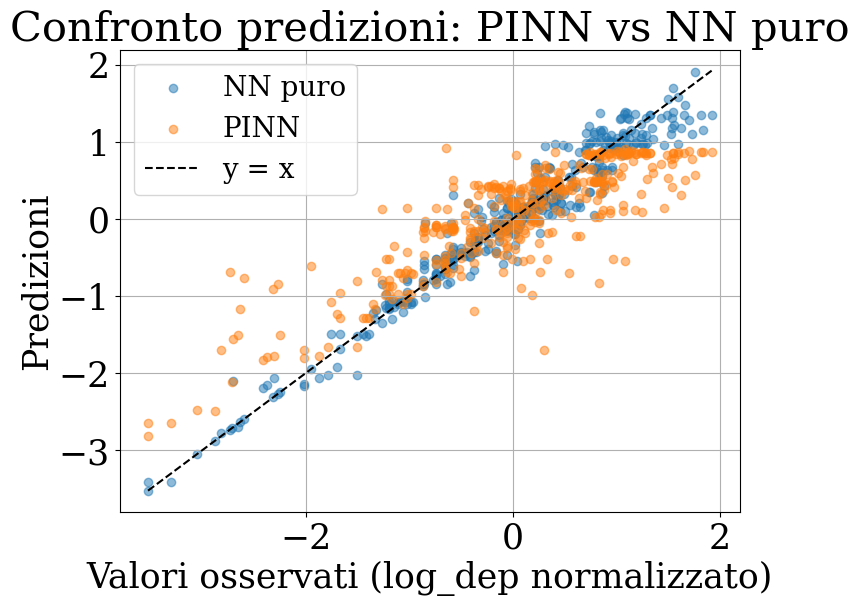

In [224]:
plt.figure(figsize=(8,6))
plt.scatter(Y_true, Y_pred_nn, label='NN puro', alpha=0.5)
plt.scatter(Y_true, Y_pred_pinn, label='PINN', alpha=0.5)
plt.plot([Y_true.min(), Y_true.max()], [Y_true.min(), Y_true.max()], 'k--', label='y = x', linewidth=1.5)
plt.xlabel("Valori osservati (log_dep normalizzato)")
plt.ylabel("Predizioni")
plt.legend()
plt.title("Confronto predizioni: PINN vs NN puro")
plt.grid(True)
plt.show()


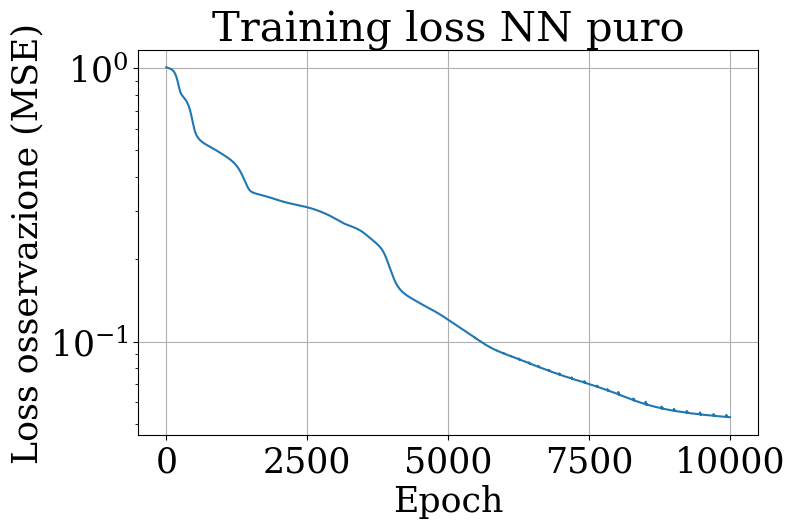

In [225]:
plt.figure(figsize=(8,5))
plt.plot(loss_history_nn, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss osservazione (MSE)")
plt.title("Training loss NN puro")
plt.grid(True)
plt.show()


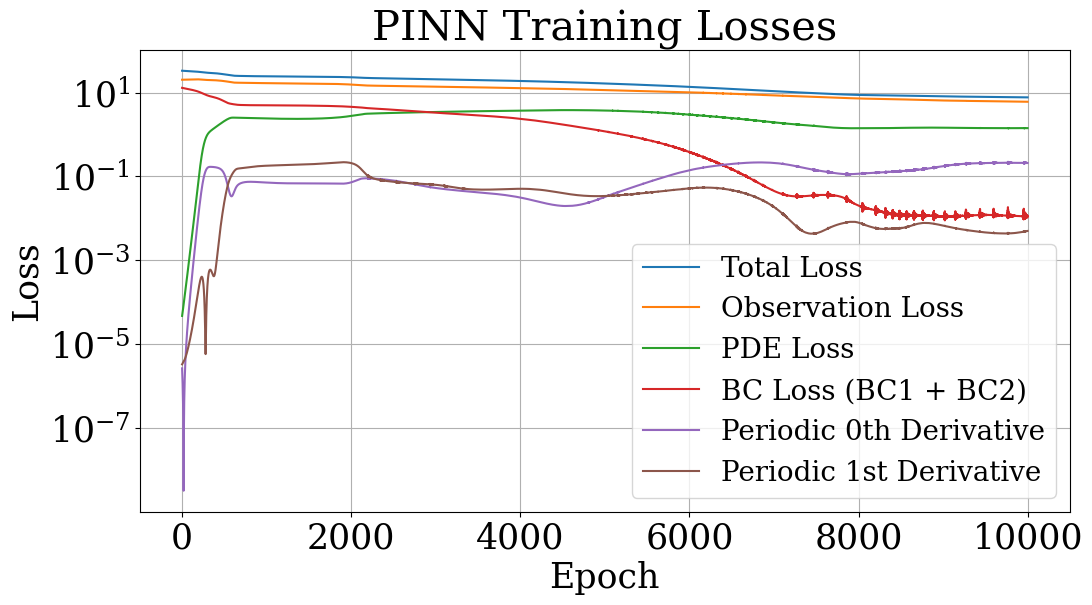

In [226]:
# === 10. Plot delle loss ===
loss_history = np.array(loss_history)
plt.figure(figsize=(12, 6))
plt.plot(loss_history[:, 0], label='Total Loss', linewidth=1.5)
plt.plot(loss_history[:, 1], label='Observation Loss', linewidth=1.5)
plt.plot(loss_history[:, 2], label='PDE Loss', linewidth=1.5)
plt.plot(loss_history[:, 3], label='BC Loss (BC1 + BC2)', linewidth=1.5)
plt.plot(loss_history[:, 4], label='Periodic 0th Derivative', linewidth=1.5)
plt.plot(loss_history[:, 5], label='Periodic 1st Derivative', linewidth=1.5)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("PINN Training Losses")
plt.show()

In [238]:
def evaluate_model_mse(model, X_obs, Y_obs_norm, df_original, target_col='log_dep'):
    """
    Valuta il modello calcolando:
    - MSE sui dati normalizzati
    - MSE sui dati originali (denormalizzati)

    Args:
        model: PINN PyTorch
        X_obs: torch.Tensor, input normalizzati
        Y_obs_norm: torch.Tensor, target normalizzati (es. log_dep_norm)
        df_original: Pandas DataFrame con colonna target originale (es. log_dep)
        target_col: Nome colonna target originale per la denormalizzazione

    Returns:
        mse_norm: float, MSE normalizzato
        mse_denorm: float, MSE denormalizzato (scala originale)
    """
    model.eval()
    with torch.no_grad():
        pred_norm = model(X_obs).cpu().numpy()
        true_norm = Y_obs_norm.cpu().numpy()

    # MSE normalizzato
    mse_norm = np.mean((pred_norm - true_norm) ** 2)

    # Denormalizzazione
    mean = df_original[target_col].mean()
    std = df_original[target_col].std()

    pred_denorm = pred_norm * std + mean
    true_denorm = df_original[target_col].values.reshape(-1, 1)

    # MSE denormalizzato
    mse_denorm = np.mean((pred_denorm - true_denorm) ** 2)

    return mse_norm, mse_denorm
#MSE per la PINN
mse_norm, mse_denorm = evaluate_model_mse(
    model=model,
    X_obs=X_obs,
    Y_obs_norm=Y_obs,
    df_original=df_empirical_Holocene,
    target_col='log_dep'
)
#MSE per la simpleNN
mse_norm_nn, mse_denorm_nn = evaluate_model_mse(
    model=model_nn,
    X_obs=X_obs,
    Y_obs_norm=Y_obs,
    df_original=df_empirical_Holocene,
    target_col='log_dep'
)
print(" Confronto MSE tra PINN e Simple NN")
print(f" PINN        | Normalizzato: {mse_norm:.6f} | Denormalizzato: {mse_denorm:.6f}")
print(f"Simple NN   | Normalizzato: {mse_norm_nn:.6f} | Denormalizzato: {mse_denorm_nn:.6f}")



 Confronto MSE tra PINN e Simple NN
 PINN        | Normalizzato: 0.302329 | Denormalizzato: 0.351405
Simple NN   | Normalizzato: 0.052840 | Denormalizzato: 0.061465


In [228]:
with open("functions_plot_calculations.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

In [229]:
# creo una griglia 1°x1°
# Definisci i range
lon_vals = np.arange(-180, 180, 1)  # Include 180
lat_vals = np.arange(-90, 90, 1)  # Include 90

# Crea la griglia con tutti i punti (lon, lat)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# Crea il DataFrame
df_global_grid_1x1 = pd.DataFrame({
    'lon': lon_flat,
    'lat': lat_flat
})

print(f"Griglia creata con {len(df_global_grid_1x1)} punti")

# Opzionale: salva su CSV
#df_global_grid_1x1.to_csv("global_grid_1x1.csv", index=False)


Griglia creata con 64800 punti


In [230]:

def calculate_save_df_torch(model, df_to_predict, mean, std, path, filename, device='cpu'):
    """
    Esegue le predizioni con un modello PyTorch e salva il risultato.

    Args:
        model (torch.nn.Module): Modello PyTorch (PINN o NN).
        df_to_predict (pd.DataFrame): DataFrame con colonne 'lon' e 'lat'.
        mean (float): Media del log_dep per denormalizzare.
        std (float): Deviazione standard del log_dep per denormalizzare.
        path (str): Cartella dove salvare il file.
        filename (str): Nome del file da salvare.
        device (str): 'cpu' o 'cuda' per eseguire il modello.
    """

    # Prepara input (normalizza e converte in tensore)
    coords = df_to_predict[['lon', 'lat']].values / 90.0
    coords_tensor = torch.tensor(coords, dtype=torch.float32).to(device)

    # Metti il modello in evaluation
    model.eval()
    with torch.no_grad():
        preds = model(coords_tensor).cpu().detach().numpy()

    # Denormalizza
    preds_denorm = preds * std + mean

    # Aggiungi colonna al DataFrame
    df_to_predict['PINN_log_dep'] = preds_denorm

    # Salva su CSV
    df_to_predict.to_csv(path + filename, index=False)


In [231]:
mean = df_empirical_Holocene['log_dep'].mean()
std = df_empirical_Holocene['log_dep'].std()


In [232]:
calculate_save_df_torch(model, df_empirical_Holocene, mean, std, RESULTS_PATH, "df_test_pinn_empirical.csv")
calculate_save_df_torch(model, df_global_grid, mean, std, RESULTS_PATH, "df_test_pinn_grid.csv")



In [233]:
df_test_pinn_empirical = pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_test_pinn_empirical.csv")
df_pinn_test_pinn_grid = pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_test_pinn_grid.csv")

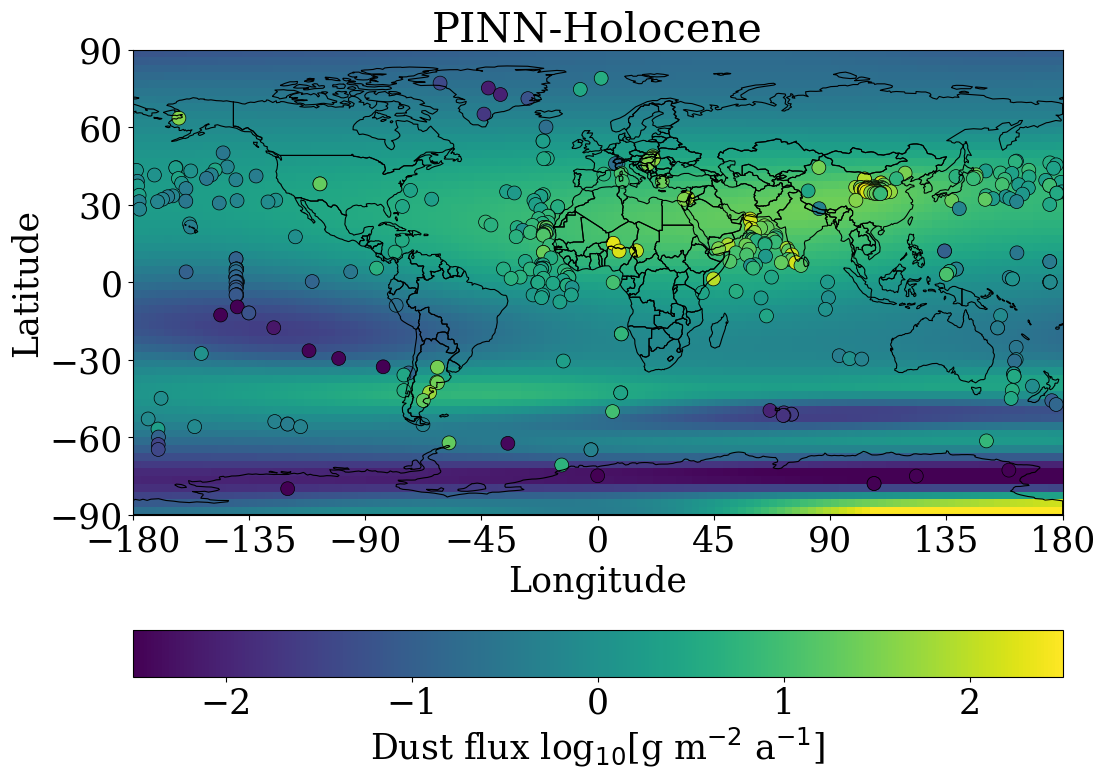

In [234]:
plot_dust_deposition_map(
    df_pinn_test_pinn_grid ,
    df_test_pinn_empirical,
    title='PINN-Holocene',
    name_to_save='PINN_MAP_empirical_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2.5,)


In [235]:
calculate_save_df_torch(model_nn, df_empirical_Holocene, mean, std, RESULTS_PATH, "df_test_nn_empirical.csv")
calculate_save_df_torch(model_nn, df_global_grid, mean, std, RESULTS_PATH, "df_test_nn_grid.csv")


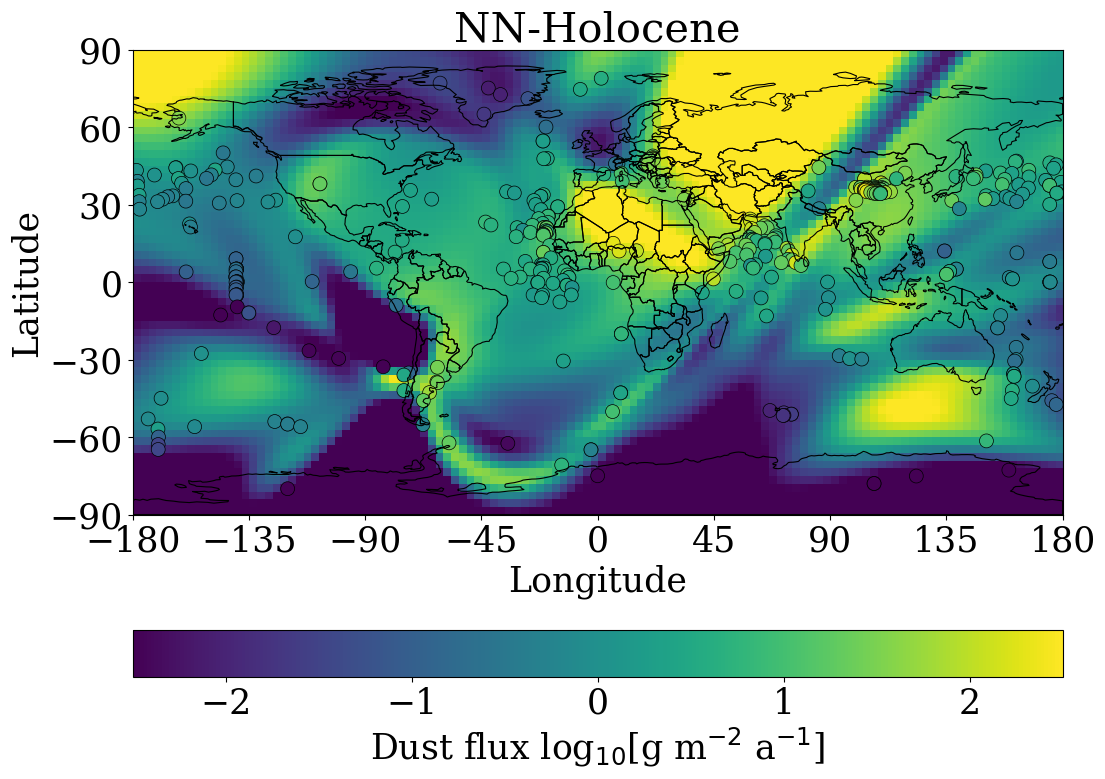

In [236]:

df_test_nn_empirical = pd.read_csv(
    "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_test_nn_empirical.csv")
df_test_nn_grid = pd.read_csv(
    "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_test_nn_grid.csv")
plot_dust_deposition_map(
    df_test_nn_grid,
    df_test_nn_empirical,
    title='NN-Holocene',
    name_to_save='PINN_MAP_empirical_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2.5, )
